<a href="https://colab.research.google.com/github/mariantocostanzo/Challange_Telecom_X_parte2/blob/main/TelecomX_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/mariantocostanzo/Challange_Telecom_X_parte2/main/datos_tratados.csv'
df = pd.read_csv(url)



In [2]:
#nombres de las columnas
print(df.columns.tolist())


['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total']


In [3]:
# Se elimina la columna 'customerID' y las filas que contengan valores nulos
df = df.drop(columns=["customerID"])
df = df.dropna()

# Verificamos que no queden valores nulos
print("¿Hay valores nulos?:", df.isnull().values.any())

# Mostramos las dimensiones del dataset limpio
print("Tamaño del DataFrame después de limpieza:", df.shape)


¿Hay valores nulos?: False
Tamaño del DataFrame después de limpieza: (7043, 20)


## 📦 Se codifican las variables categóricas

| Tipo de variable                           | Método aplicado|
| ------------------------------------------ | ------------------------------------- |
| Categóricas binarias (2 valores)           | Label Encoding (`Yes`→1, `No`→0)      |
| Categóricas no binarias (más de 2 valores) | One-Hot Encoding (columnas separadas) |


In [4]:
from sklearn.preprocessing import LabelEncoder

# 1.'account.Charges.Total' a numérico
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# 2. Se identifican las columnas categóricas
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# 3. Se detectan las binarias (solo 2 valores únicos, ignorando NaNs)
binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]

# 4. Se aplica Label Encoding a columnas binarias
label_encoder = LabelEncoder()
for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])

# 5. Se aplica One-Hot Encoding al resto de las columnas categóricas
multi_cat_cols = [col for col in categorical_cols if col not in binary_cols]
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# Se muestran las primeras filas del DataFrame transformado
df.head()


,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total,...,internet.TechSupport_Yes,internet.StreamingTV_No internet service,internet.StreamingTV_Yes,internet.StreamingMovies_No internet service,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,0,0,1,1,9,1,1,65.6,593.30,...,True,False,True,False,False,True,False,False,False,True
1,0,1,0,0,0,9,1,0,59.9,542.40,...,False,False,False,False,True,False,False,False,False,True
2,1,1,0,0,0,4,1,1,73.9,280.85,...,False,False,False,False,False,False,False,False,True,False
3,1,1,1,1,0,13,1,1,98.0,1237.85,...,False,False,True,False,True,False,False,False,True,False
4,1,0,1,1,0,3,1,1,83.9,267.40,...,True,False,True,False,False,False,False,False,False,True


## ✅ Proporción entre los que cancelaron y no

In [5]:
# Cantidad de clientes que cancelaron y los que no
cancel_counts = df['Churn'].value_counts()

# Total y porcentaje de cada clase
print("Cantidad por clase:")
print(cancel_counts)

print("\nProporción por clase:")
print(cancel_counts / cancel_counts.sum())


Cantidad por clase:
Churn
0    5174
1    1869
Name: count, dtype: int64

Proporción por clase:
Churn
0    0.73463
1    0.26537
Name: count, dtype: float64


##✅ Código para escalar las variables numéricas
##Se uso StandardScaler, que estandariza con media 0 y desviación 1


In [6]:
from sklearn.preprocessing import StandardScaler

# Identificamos columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('Churn')  # No queremos escalar la variable objetivo

# Creamos un escalador
scaler = StandardScaler()

# Aplicamos el escalado a las columnas numéricas
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Mostramos un ejemplo
df_scaled[numeric_cols].head()


,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total
0,-1.009559,-0.439916,1.034530,1.529024,-0.951682,0.327438,0.829798,0.027862,-0.745607
1,0.990532,-0.439916,-0.966622,-0.654012,-0.951682,0.327438,-1.205113,-0.161583,-0.768063
2,0.990532,-0.439916,-0.966622,-0.654012,-1.155283,0.327438,0.829798,0.303720,-0.883456
3,0.990532,2.273159,1.034530,-0.654012,-0.788800,0.327438,0.829798,1.104706,-0.461240
4,-1.009559,2.273159,1.034530,-0.654012,-1.196004,0.327438,0.829798,0.636080,-0.889390


##✅ Cálculo y vizualición de la matriz de correlación


/tmp/ipython-input-4038040072.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_corr.values, y=churn_corr.index, palette=colors, legend=False)


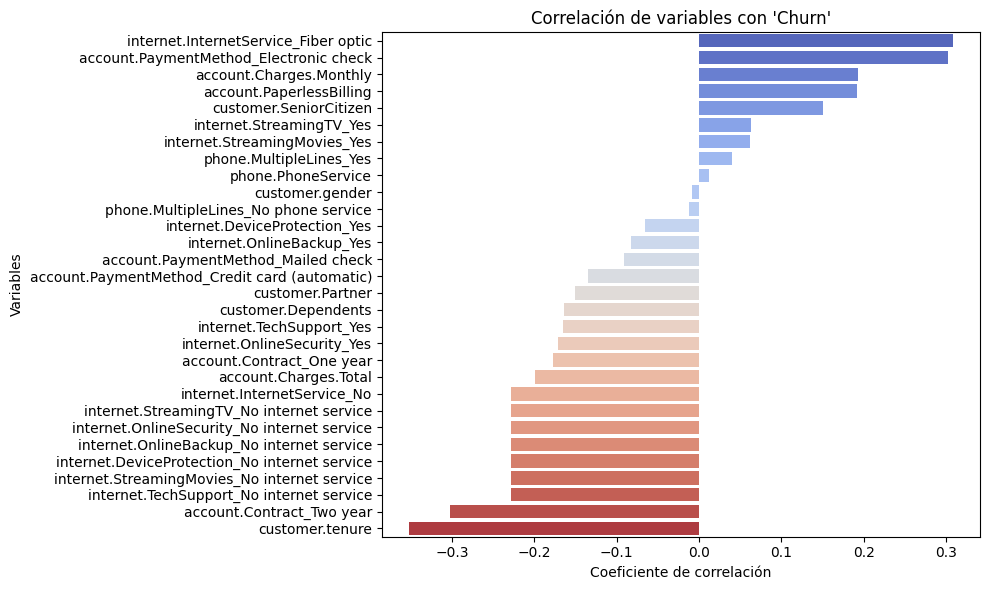

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# se ordenan las correlaciones con Churn
churn_corr = df.corr(numeric_only=True)["Churn"].drop("Churn").sort_values(ascending=False)

# lista de colores basada en los valores de correlación
colors = sns.color_palette("coolwarm", len(churn_corr))
colors = [colors[i] for i in range(len(colors))]

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_corr.values, y=churn_corr.index, palette=colors, legend=False)
plt.title("Correlación de variables con 'Churn'")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()




##🔟 Top 10 variables más correlacionadas con Churn:

##Las variables con correlación positiva alta (más propensas a que el cliente cancele):

| Variable                              | Correlación alta positiva  |
|---------------------------------------|----------------------------|
| internet.InternetService_Fiber optic  | +0.3 aprox.                |
| account.PaymentMethod_Electronic check| +0.3 aprox.                |
| account.Charges.Monthly               | +0.25 aprox.               |
| account.PaperlessBilling              | +0.2 aprox.                |
| customer.SeniorCitizen                | +0.15 aprox.               |

###Estas variables aumentan la probabilidad de que un cliente cancele.

##Las variables con correlación negativa (más asociadas a permanencia):

| Variable                               | Correlación negativa     |
|----------------------------------------|--------------------------|
| customer.tenure                        | –0.35 aprox.             |
| account.Contract_Two year              | –0.3 aprox.              |
| internet.TechSupport_No                | –0.25 aprox.             |
| account.Contract_One year              | –0.2 aprox.              |
| internet.OnlineSecurity_Yes            | –0.2 aprox.              |   

###Estas reducen la probabilidad de cancelación (fidelidad del cliente).



/tmp/ipython-input-1904448643.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette=colors)


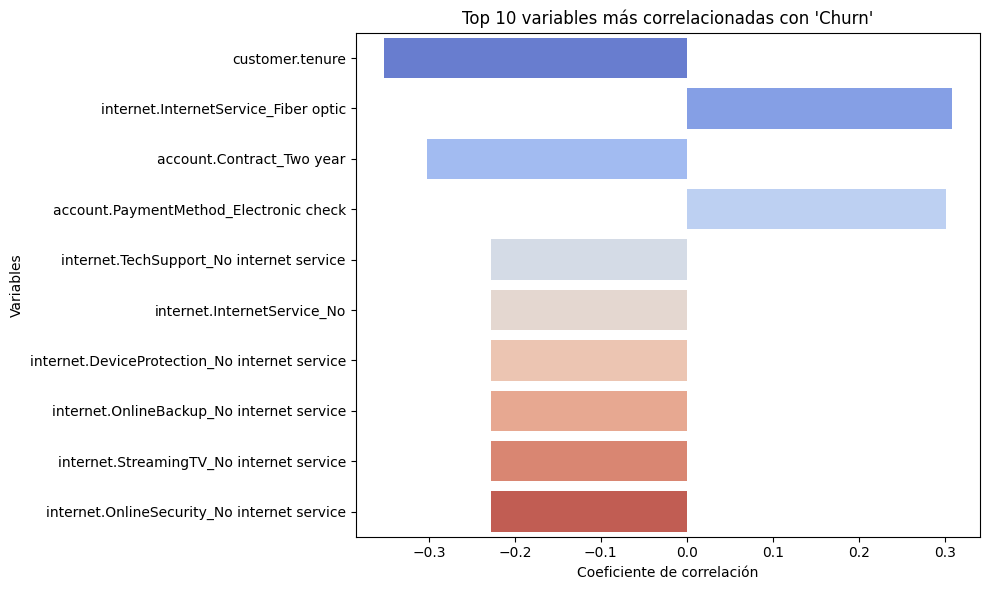

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Se ordenana las correlaciones por valor absoluto
churn_corr_abs = churn_corr.abs().sort_values(ascending=False)

#top 10 variables
top_10_corr = churn_corr.loc[churn_corr_abs.head(10).index]

# lista de colores basada en los valores de correlación
colors = sns.color_palette("coolwarm", len(top_10_corr))


plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette=colors)
plt.title("Top 10 variables más correlacionadas con 'Churn'")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

In [18]:
df.to_csv("df_transformado.csv", index=False)

#analisis dirigido#
📊 1. Tiempo de contrato (customer.tenure) × Cancelación.
Se uso un boxplot para ver cómo varía el tiempo de permanencia según si el cliente canceló o no.

📊 2. Gasto total (account.Charges.Total) × Cancelación.
Se uso un scatter plot para comparar cuánto gastaron los clientes que cancelaron frente a los que no.

/tmp/ipython-input-2614957196.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="customer.tenure", data=df, palette=["lightcoral", "lightcoral"])


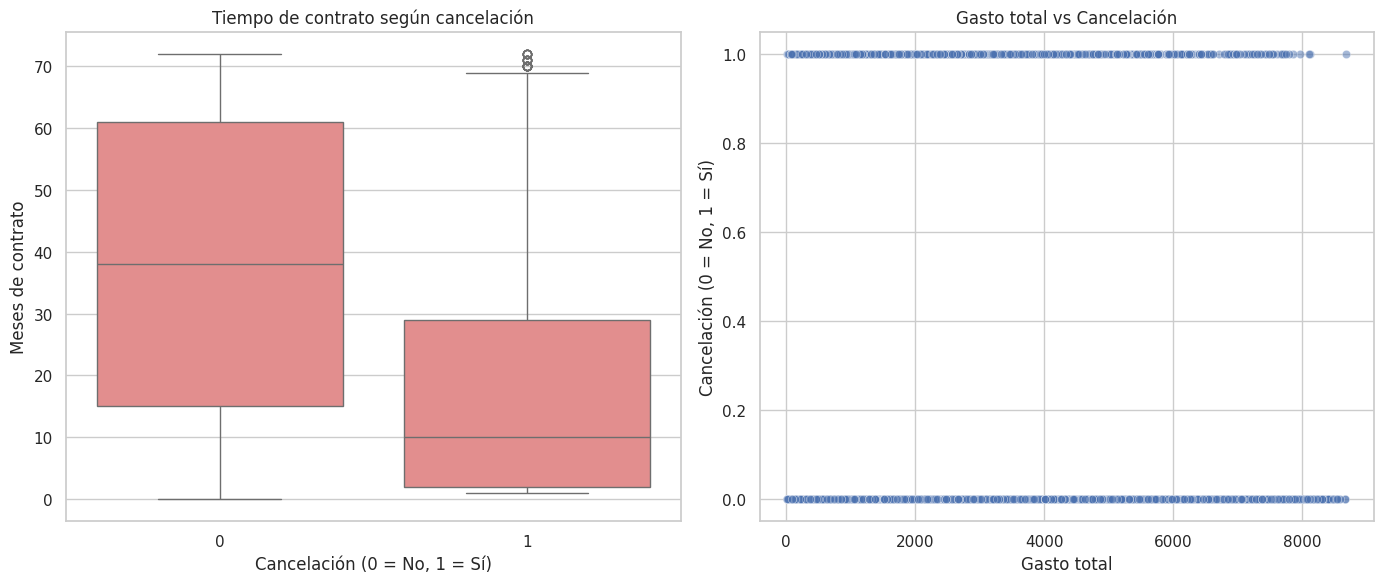

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset transformado
df = pd.read_csv("df_transformado.csv")

# Estilo
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# Gráfico 1: Boxplot - Tiempo de contrato vs Cancelación
plt.subplot(1, 2, 1)
sns.boxplot(x="Churn", y="customer.tenure", data=df, palette=["lightcoral", "lightcoral"])
plt.title("Tiempo de contrato según cancelación")
plt.xlabel("Cancelación (0 = No, 1 = Sí)")
plt.ylabel("Meses de contrato")

# Gráfico 2: Scatter plot - Gasto total vs Cancelación
plt.subplot(1, 2, 2)
sns.scatterplot(x="account.Charges.Total", y="Churn", data=df, alpha=0.5)
plt.title("Gasto total vs Cancelación")
plt.xlabel("Gasto total")
plt.ylabel("Cancelación (0 = No, 1 = Sí)")

plt.tight_layout()
plt.show()


#Separación de Datos
##👉 Separa el dataset en dos partes:

X: contiene todas las columnas menos "Churn" (las características o variables independientes).

y: contiene la columna "Churn" (la variable objetivo que queremos predecir: si el cliente cancela o no).



In [11]:
from sklearn.model_selection import train_test_split

# Separar variables predictoras y variable objetivo
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Dividir 80% entrenamiento y 20% prueba, estratificando por la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Verificación de tamaños
print("Tamaño de entrenamiento:", X_train.shape[0])
print("Tamaño de prueba:", X_test.shape[0])
print("Total:", df.shape[0])


Tamaño de entrenamiento: 5634
Tamaño de prueba: 1409
Total: 7043


#Creación de Modelos

✅ 1. Modelo 1: Regresión Logística (requiere normalización)
Usa distancias internas y cálculo de coeficientes → necesita que las variables estén en la misma escala.

✅ 2. Modelo 2: Random Forest (no requiere normalización)
Basado en árboles → no le afecta la escala.



In [12]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Separar features y target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ================================
# MODELO 1: Regresión Logística (con imputación y normalización)
# ================================
pipeline_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(solver='liblinear'))
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

# ================================
# MODELO 2: Random Forest (con imputación, sin normalización)
# ================================
pipeline_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

# ================================
# Evaluación
# ================================
print("🔹 Regresión Logística")
print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

print("🔹 Random Forest")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


🔹 Regresión Logística
Acurácia: 0.794180269694819
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

🔹 Random Forest
Acurácia: 0.7849538679914834
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.63      0.46      0.53       374

    accuracy                           0.78      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



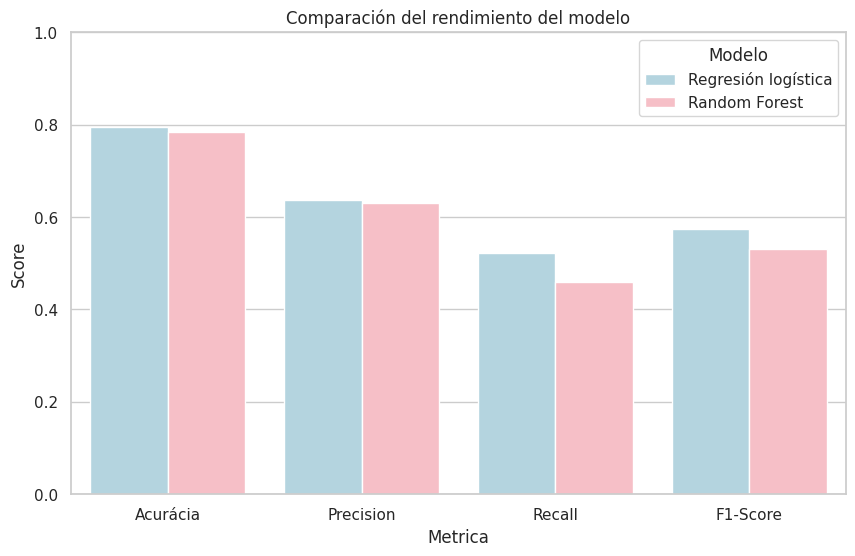

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report


report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)


metrics_lr = {
    'Acurácia': report_lr['accuracy'],
    'Precision': report_lr['1']['precision'],
    'Recall': report_lr['1']['recall'],
    'F1-Score': report_lr['1']['f1-score']
}

metrics_rf = {
    'Acurácia': report_rf['accuracy'],
    'Precision': report_rf['1']['precision'],
    'Recall': report_rf['1']['recall'],
    'F1-Score': report_rf['1']['f1-score']
}

# Creación del  DataFrame para el plotting
metrics_df = pd.DataFrame({
    'Metrica': metrics_lr.keys(),
    'Regresión logística': metrics_lr.values(),
    'Random Forest': metrics_rf.values()
})

metrics_df_melted = metrics_df.melt(id_vars='Metrica', var_name='Modelo', value_name='Score')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Metrica', y='Score', hue='Modelo', data=metrics_df_melted, palette=["lightblue", "lightpink"])
plt.title('Comparación del rendimiento del modelo')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

## Matriz de confusión

Matriz de confusión de cada modelo para ver qué tan bien se desempeñan al clasificar a los clientes que abandonan y los que no.

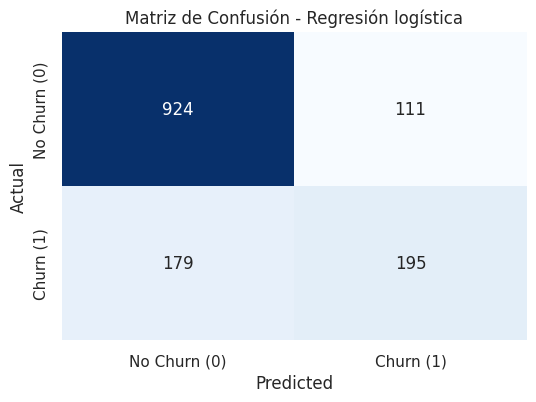

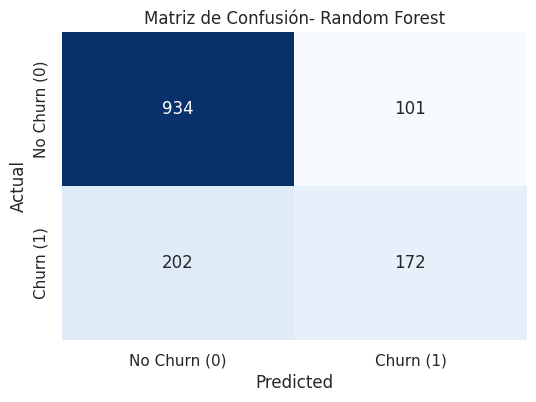

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de Confusión para regresión logística
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Regresión logística')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['No Churn (0)', 'Churn (1)'])
plt.yticks([0.5, 1.5], ['No Churn (0)', 'Churn (1)'])
plt.show()

# Matriz de ConfusiónRandom Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión- Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['No Churn (0)', 'Churn (1)'])
plt.yticks([0.5, 1.5], ['No Churn (0)', 'Churn (1)'])
plt.show()

###Considerando la importancia de identificar los casos reales de cancelación (Recall) y el equilibrio general entre precisión y recall (Puntuación F1) para la clase de cancelación, el modelo de Regresión Logística parece tener un rendimiento ligeramente mejor para este problema específico, aunque la precisión general sea similar.

# Informe Detallado sobre la Cancelación de Clientes

Se presenta un análisis de los factores que influyen en la cancelación de clientes (Churn) y se evalúa el rendimiento de dos modelos de clasificación para predecir este comportamiento.

## 1. Factores Clave que Influyen en la Cancelación

Basándonos en el análisis de correlación, las variables que muestran una mayor influencia (positiva o negativa) en la cancelación son:

*   **Correlación Positiva Alta (mayor probabilidad de cancelación):**
    *   `internet.InternetService_Fiber optic`: Los clientes con servicio de fibra óptica tienden a cancelar más.
    *   `account.PaymentMethod_Electronic check`: El método de pago por cheque electrónico está asociado a una mayor tasa de cancelación.
    *   `account.Charges.Monthly`: Un mayor cargo mensual se correlaciona positivamente con la cancelación.
    *   `account.PaperlessBilling`: Los clientes con facturación electrónica tienden a cancelar más.
    *   `customer.SeniorCitizen`: Los clientes de la tercera edad tienen una mayor propensión a cancelar.

*   **Correlación Negativa Alta (menor probabilidad de cancelación - mayor fidelidad):**
    *   `customer.tenure`: Los clientes con mayor tiempo de permanencia son menos propensos a cancelar.
    *   `account.Contract_Two year`: Los contratos de dos años están fuertemente asociados a la permanencia.
    *   `internet.TechSupport_No internet service`: La falta de soporte técnico está relacionada con una mayor cancelación.
    *   `account.Contract_One year`: Los contratos de un año también reducen la probabilidad de cancelación, aunque en menor medida que los de dos años.
    *   `internet.OnlineSecurity_Yes`: Tener seguridad online se asocia a una menor cancelación.

## 2. Rendimiento de los Modelos de Clasificación

Se evaluaron dos modelos: Regresión Logística y Random Forest. Los resultados obtenidos en el conjunto de prueba son los siguientes:

| Métrica   | Regresión Logística | Random Forest |
| :-------- | :------------------ | :------------ |
| Accuracy  | 0.794               | 0.785         |
| Precision (Churn) | 0.637               | 0.630         |
| Recall (Churn)    | 0.521               | 0.460         |
| F1-Score (Churn)  | 0.574               | 0.532         |

**Análisis del Rendimiento:**

*   Ambos modelos tienen una precisión general similar.
*   La **Regresión Logística** muestra un rendimiento ligeramente mejor en las métricas clave para la clase minoritaria (Churn):
    *   Mayor **Recall**, lo que significa que identifica una mayor proporción de clientes que realmente cancelan. Esto es crucial para implementar estrategias de retención.
    *   Mayor **Puntuación F1**, que indica un mejor equilibrio entre precisión y recall para la clase de interés.
*   El **Random Forest**, aunque con una precisión similar, tiene un recall más bajo, lo que implica que deja pasar a más clientes que sí cancelarán.

**Matrices de Confusión:**

Las matrices de confusión detallan las predicciones de cada modelo:

**Regresión Logística:**
*   Verdaderos Positivos (predice Churn correctamente): 195
*   Falsos Positivos (predice Churn incorrectamente): 111
*   Verdaderos Negativos (predice No Churn correctamente): 924
*   Falsos Negativos (predice No Churn incorrectamente): 179

**Random Forest:**
*   Verdaderos Positivos: 172
*   Falsos Positivos: 101
*   Verdaderos Negativos: 934
*   Falsos Negativos: 202

La Regresión Logística identifica 195 casos de Churn correctamente, mientras que Random Forest identifica 172. La Regresión Logística también tiene menos Falsos Negativos (179 vs 202), lo que refuerza su mejor capacidad para detectar la cancelación.

## 3. Estrategias de Retención Propuestas

Basándonos en los factores clave de influencia y el rendimiento del modelo de Regresión Logística (considerado ligeramente superior para este caso):

*   **Foco en Clientes con Fibra Óptica y Pago Electrónico:** Implementar programas de satisfacción específicos o revisar los posibles puntos de negativos para clientes que usan estos servicios o métodos de pago.
*   **Monitoreo de Cargos Mensuales:** Identificar a los clientes con cargos mensuales elevados y evaluar la posibilidad de ofrecerles planes alternativos o descuentos antes de que consideren cancelar.
*   **Incentivar Contratos a Largo Plazo:** Promover activamente los contratos de uno y, especialmente, de dos años, destacando sus beneficios y ofreciendo incentivos por la renovación a largo plazo.
*   **Mejorar el Soporte Técnico:** Dado que la falta de soporte técnico se asocia con la cancelación, invertir en mejorar la calidad y accesibilidad del soporte puede ser una estrategia de retención efectiva.
*   **Resaltar los Beneficios de la Seguridad Online:** Educar a los clientes sobre la importancia y los beneficios de la seguridad online para fomentar su adopción y, potencialmente, aumentar la permanencia.
*   **Programas para Clientes Antiguos:** Reconocer y recompensar la fidelidad de los clientes con mayor antigüedad (`customer.tenure`) para reforzar su compromiso.

## Conclusión

El análisis de datos ha revelado que factores como el tipo de servicio de internet, el método de pago, el cargo mensual y el tipo de contrato son determinantes en la decisión de un cliente de cancelar. El modelo de Regresión Logística demostró ser levemente mejor en la identificación de clientes propensos a cancelar. Las estrategias de retención deben enfocarse en abordar los puntos débiles identificados en los factores de alta correlación positiva e incentivar aquellos asociados a la permanencia.